# Python Version of "Particle Filter Explained without Equations"

This is the matlab code behind the movie "Particle Filter Explained without Equations", which can be found at http://youtu.be/aUkBa1zMKv4

Written by Andreas Svensson, October 2013
Updated by Andreas Svensson, February 2013, fixing a coding error in the 'propagation-update' of the weights
Translated to Python by Joshua Saunders, February 2021

andreas.svensson@it.uu.se
http://www.it.uu.se/katalog/andsv164

josh137@gatech.edu

The code is provided as is, and I take no responsibility for what this
code may do to you, your computer or someone else.

This code is licensed under a
Creative Commons Attribution-ShareAlike 3.0 Unported License.
http://creativecommons.org/licenses/by-sa/3.0/

In [8]:
import time

import numpy as np
import matplotlib.pyplot as plt
import scipy


# Setting the random seed, so the same example can be run several times
np.random.seed(0)
randn = np.random.default_rng().standard_normal

In [2]:
def linspace(start, stop, size):
    return np.linspace(start, stop, int((stop-start)/size))

In [3]:
# Some unceratinty parameters
measurement_noise_stdev = 0.1 
speed_stdev = 1

# Speed of the aircraft
speed = 1

# Set starting position of aircraft
plane_pos_x = -25
plane_pos_y = 4

# Some parameters for plotting the particles
m = 1000
k = 0.0001

# Number of particles
N = 200

# Some variables for plotting
step_size = 0.01
plot_vector_sea = linspace(-10., 10., 0.01)
plot_vector_mountains = np.concatenate((linspace(-40., -10., 0.01), linspace(10., 40., 0.01)))
# plot_vector_mountains = np.concatenate([
#     np.arange(-40., -10.+step_size, step_size), np.arange(10+step_size, 40, step_size)
# ])

plot_height = 5

In [4]:
def plot_plane(position, axis):
    """Plots a figure that resembles a plane
    
    Arguments:
        position: a tuple (or list) that contains the x- and y-coordinates of the plane, respectively
        axis: the axis of the pyplot figure to plot the plane in

    Returns:
        None
    """
    x_pos, y_pos = position
    x = x_pos - 0.6 + np.array([-1.0,  -0.1,  -0.09, 0.3,   0.7,  0.8, 0.7,  0.3, -0.09, -0.1, -1.0])
    y = y_pos +       np.array([-0.05, -0.05, -0.4, -0.05, -0.05, 0.0, 0.05, 0.05, 0.4,   0.05, 0.05])
    return axis.fill(x, y, 'k')


def ground(x):
    """This function describes the ground"""
    g = (x>=10)*((1-(x-10)/30)*np.sin(x-10)+((x-10)/30)*np.sin(1.5*(x-10))+0.2*(x-10)*(x<=20)+2*(x>20))+ \
    (x<=-10)*((1-(-x-10)/30)*np.sin(-x-10)+((-x-10)/30)*np.sin(1.5*(-x-10))+0.2*(-x-10)*(x>=-20)+2*(x<-20))
    return g

([], [])

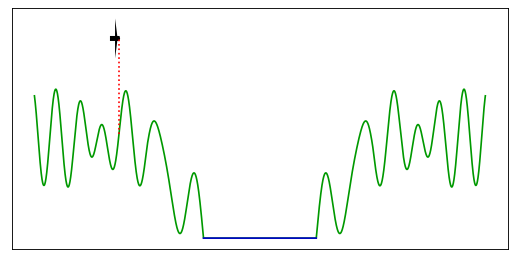

In [5]:
# Plot the environment
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)

# plot the mountains and sea
ax.plot(plot_vector_mountains, ground(plot_vector_mountains), color=[0, 0.6, 0])
ax.plot(plot_vector_sea, ground(plot_vector_sea), color=[0, 0, 0.8])
plane = plot_plane((plane_pos_x, plane_pos_y), ax)
measurement_line = plt.plot(
    [plane_pos_x, plane_pos_x], [ground(plane_pos_x), plane_pos_y],
    color=[1, 0, 0], linestyle=':'
)

# Remove the x- and y-ticks
plt.xticks([])
plt.yticks([])

## Begin Filtering

In [6]:
# Generate particles
particles = np.random.rand(N) * 80 - 40

# Plot particles
particle_handle = ax.scatter(particles, plot_height*np.ones(particles.size), m*(1/N*np.ones(N)+k), 'k')

first_run = True

# Initialize particle weights
w = (1 / N) * np.ones((N, 1))

In [7]:
T = 60
for t in range(T):
    # Generate height measurements (with gaussian measurement noise)
    plane_meas_dist = plane_pos_y - ground(plane_pos_x) + randn() * measurement_noise_stdev

    # Evaluate measurements (i.e., create weights) using the pdf for the normal distribution
    w = w*(1/(np.sqrt(2*pi)*measurement_noise_stdev)*np.exp(-((plane_pos_y-ground(particles))-plane_meas_dist)**2 \ 
        / (2*measurementNoiseStdev**2)))
    
    # Normalize
    w = w / np.sum(w)

    if first_run:
        # Sort out some particles to evaluate them in "public" the first
        # run (as in the movie)
        order = np.sort(w)[::-1]
        pmax = order[0]
        pmaxi = np.setdiff1d(np.linspace(1, N), pmax)
        del particle_handle
        # TODO: finish the line immediately below
        particle_handle = plt.scatter([[particles[pmaxi], [plot_height*np.ones(particles.size)]]])
        time.sleep(1)

        pmax2 = order[1]
        pmaxi2 = np.setdiff1d(pmaxi, pmax2)
        del particle_handle
        # TODO: finish the line immediately below
        particle_handle = plt.scatter([[particles[pmaxi], [plot_height*np.ones(particles.size)]]])
        time.sleep(1)

        # Plot all weighted particles
        del particle_handle
        # TODO: finish the line immediately below
        particle_handle = plt.scatter([[particles[pmaxi], [plot_height*np.ones(particles.size)]]])
        time.sleep(1)

    # Resample the particles
    u = np.random.rand(N, 1)
    wc = np.cumsum(w, axis=1)
    ind1 = np.sort([u, wc])
    ind = np.where(ind1 <= N) - np.arange(N).reshape((N, 1))
    particles = particles[ind]
    w = np.ones((N, 1)) / N

    del particle_handle
    # TODO: finish the line immediately below
    particle_handle = plt.scatter([[particles[pmaxi], [plot_height*np.ones(particles.size)]]])
    time.sleep(1)

    # Time propagation
    speed_noise = speed_stdev * np.random.rand(particles.size)
    particles = particles + speed + speed_noise

    # Update weights
    # w = w, since the update in the previous step is done using our motion model, so the
    # information is already contained in that update

    # Move and plot moved aircraft
    plane_pos_x += speed
    del plane
    del measurement_line
    plane = plot_plane((plane_pos_x, plane_pos_y), ax)
    measurement_line = plt.plot(
        [plane_pos_x, plane_pos_x], [ground(plane_pos_x), plane_pos_y],
        color=[1, 0, 0], linestyle=':'
    )
        
    if first_run:
        # Plot updated particles
        del particle_handle
        # TODO: finish the line immediately below
        particle_handle = plt.scatter([[particles[pmaxi], [plot_height*np.ones(particles.size)]]])
    
    first_run = False